In [48]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from collections import Counter
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
base_path = Path('../input/chexpert')
train_data_path = base_path / 'train'
test_data_path = base_path / 'test'
train_labels_path = base_path / 'train_labels.csv'

def load_data(file_path):
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

train_df = load_data(base_path / 'CheXpert-v1.0-small/train.csv')
valid_df = load_data(base_path / 'CheXpert-v1.0-small/valid.csv')

if train_df is not None:
    print("Training data loaded successfully.")
else:
    print("Failed to load training data.")

if valid_df is not None:
    print("Validation data loaded successfully.")
else:
    print("Failed to load validation data.")

Training data loaded successfully.
Validation data loaded successfully.


In [38]:
chexnet_targets = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                   'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                   'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                   'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [39]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [40]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

In [41]:
def feature_string(row):
    active_features = [
        feature for feature in u_one_features if row[feature] in [-1, 1]
    ] + [
        feature for feature in u_zero_features if row[feature] == 1
    ]
    
    return ';'.join(active_features)

In [42]:
train_df['train_valid'] = False
valid_df['train_valid'] = True

In [43]:
train_df['patient'] = train_df['Path'].str.split('/', expand=True)[2]
train_df['study'] = train_df['Path'].str.split('/', expand=True)[3]

valid_df['patient'] = valid_df['Path'].str.split('/', expand=True)[2]
valid_df['study'] = valid_df['Path'].str.split('/', expand=True)[3]

In [44]:
df = pd.concat([train_df, valid_df])
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [45]:
df['feature_string'] = df.apply(feature_string,axis = 1).fillna('')
df['feature_string'] = df['feature_string'] .apply(lambda x:x.split(";"))
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1,[]
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2,"[Atelectasis, Edema]"
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,[]
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,[]
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,[Edema]


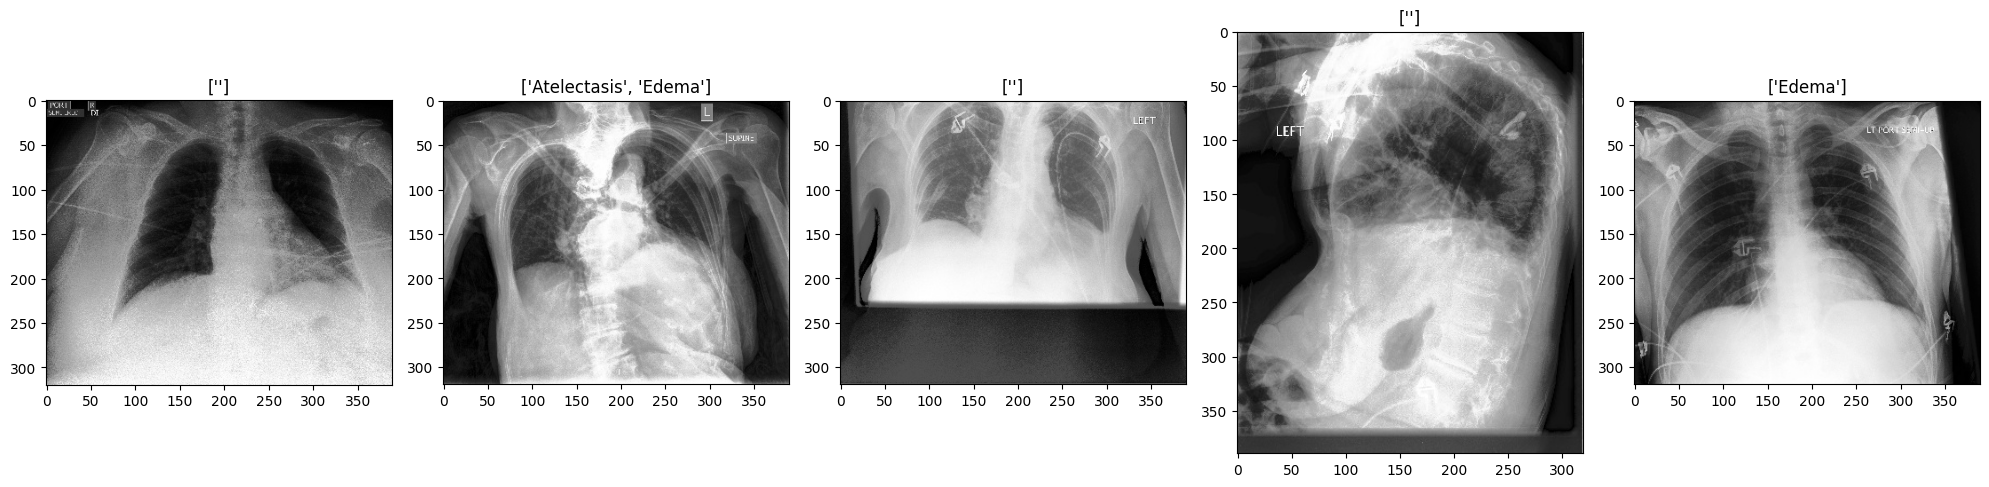

In [46]:
image_paths = full_df['Path'].head(5)
image_labels = full_df['feature_string'].head(5)
fig, axes = plt.subplots(1, len(image_labels), figsize=(20, 10))
for ax, path, label in zip(axes, image_paths, image_labels):
    image = cv2.imread(os.path.join(data_path, path))
    ax.imshow(image)
    ax.set_title(label)
plt.tight_layout()
plt.show()

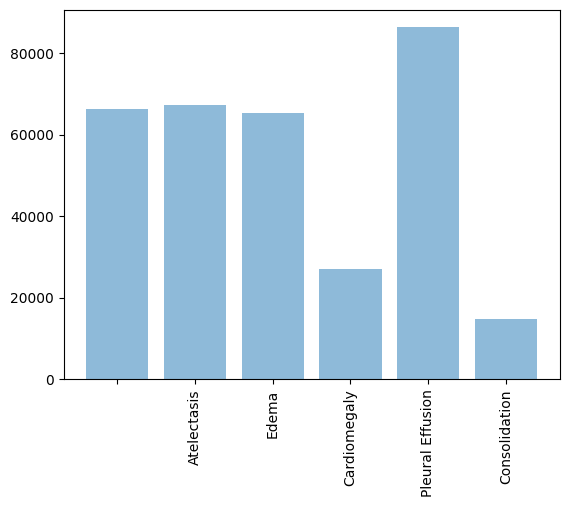

In [49]:
all_labels = [label for chexpert_targets in df['feature_string'] for label in chexpert_targets]
label_counts = Counter(all_labels)
plt.bar(label_counts.keys(), label_counts.values(), alpha=0.5)
plt.xticks(rotation='vertical')
plt.show()

In [51]:
sample_percentage = 0.00
train_df1 = df[~df['train_valid']]
valid_df1 = df[df['train_valid']]
unique_patients = train_df1['patient'].unique()
sample_mask = np.random.rand(len(unique_patients)) < sample_percentage
sampled_patients = unique_patients[sample_mask]
dev_set = train_df1[train_df1['patient'].isin(sampled_patients)]
train_set = train_df1[~train_df1['patient'].isin(sampled_patients)]
print(f"Validation set size: {valid_df1['Path'].size}")
print(f"Training set size: {train_set['Path'].size}")

Validation set size: 234
Training set size: 223414


In [52]:
datagen=image.ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.1)
test_datagen=image.ImageDataGenerator(rescale=1./255)

In [53]:
def generate_datasets(image_size = 224):

    train_generator=datagen.flow_from_dataframe(dataframe=train_set, directory=data_path, 
                                                x_col="Path", y_col="feature_string", has_ext=True, seed = 42, #classes = chexpert_targets,
                                                class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "training")

    validation_generator = datagen.flow_from_dataframe(dataframe=train_set, directory=data_path, 
                                                       x_col="Path", y_col="feature_string", has_ext=True, seed = 42, #classes = chexpert_targets,
                                                       class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "validation")

    test_generator = test_datagen.flow_from_dataframe(dataframe=valid_df1, directory=data_path, 
                                                      target_size=(image_size,image_size),class_mode='categorical',
                                                      batch_size=1, shuffle=False,
                                                      x_col="Path", y_col="feature_string")
    
    return [train_generator,validation_generator,test_generator]

In [54]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [55]:
def build_model(image_size = 224, load_previous_weights = True, freeze_cnn = False):
    base_model = DenseNet121(include_top= False, input_shape=(image_size,image_size,3), weights='imagenet')

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D(input_shape=(1024,1,1))(x)
    # Add a flattern layer 
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # Add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # and a logistic layer --  we have 5 classes
    predictions = Dense(6, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Recover previously trained weights
    if load_previous_weights:
        try:
            model.load_weights('../input/chexpert-keras-base/weights.hdf5')
            print('Weights successfuly loaded')
        except:
            print('Weights not loaded')

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    if freeze_cnn:
        for layer in base_model.layers:
            layer.trainable = False
        
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', auc])
        
    return model

In [56]:
def train_model(model , datasets, epochs=1, image_size = 75):
    
    checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                                   verbose=1, save_best_only=True)
    
    train_generator,validation_generator,test_generator = datasets
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    print(STEP_SIZE_TRAIN)
    print(STEP_SIZE_VALID)

    history = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, callbacks = [checkpointer])
    return history

In [58]:
image_size_input = 75
model = build_model(image_size = image_size_input)

Weights not loaded


In [59]:
datasets = generate_datasets(image_size = image_size_input)
train_generator,validation_generator,test_generator = datasets

KeyboardInterrupt: 